In [3]:
from google.colab import files
uploaded = files.upload()

Saving tabela3416.xlsx to tabela3416.xlsx


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing  import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

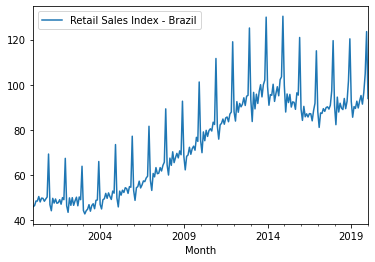

In [4]:
df = pd.read_excel('tabela3416.xlsx', index_col='Brasil e Unidade da Federação', decimal=',')
df.index.name = "Month"
df = pd.DataFrame(df['Brasil'])
df.columns = ['Retail Sales Index - Brazil']
df.plot()

# CREATING THE MODEL

Epoch 1/200
205/205 [==============================] - 5s 26ms/step - loss: 0.0217 - val_loss: 0.0235
Epoch 2/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0123 - val_loss: 0.0240
Epoch 3/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 4/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 5/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0093 - val_loss: 0.0142
Epoch 6/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 7/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 8/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 9/200
205/205 [==============================] - 5s 23ms/step - loss: 0.0033 - val_loss: 0.0086
Epoch 10/200
205/205 [==============================] - 5s 23ms/step - loss: 0.003

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


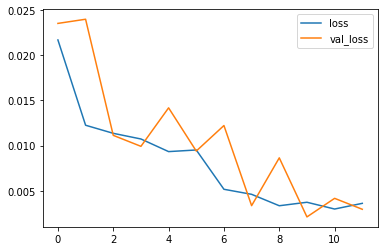

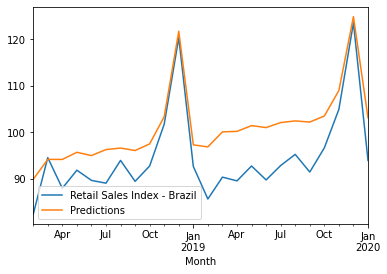

In [0]:
# Creating a 24 months test size (1.5 years)
test_size = 24
# Length of Batches, 12 months = 1 year to capture seasonality
length = 12
test_ind = len(df) - test_size
# Split data
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
# Scaling Data
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time series generator, creating batches
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)
#############################
# Creating the model
n_features = 1 # Just one feature, Sales Index

model = Sequential()
model.add(LSTM(200, activation='relu',input_shape=(length,n_features), return_sequences=True))
model.add(LSTM(200, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

# Creates an early stop mechanism
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                           length=length, batch_size=1)
# Fitting the model
model.fit(generator,epochs=200,
          validation_data=validation_generator,
          callbacks=[early_stop])

# Plotting model loss
losses =pd.DataFrame(model.history.history)
losses.plot()

test_predictions = []

# For loop creating a predictions df
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot()

rms = np.sqrt(mean_squared_error(test.iloc[:,0], test.iloc[:,1]))
print(rms)

# FORECASTING


Epoch 1/13
217/217 [==============================] - 8s 39ms/step - loss: 0.0206
Epoch 2/13
217/217 [==============================] - 9s 39ms/step - loss: 0.0157
Epoch 3/13
217/217 [==============================] - 9s 39ms/step - loss: 0.0148
Epoch 4/13
217/217 [==============================] - 9s 39ms/step - loss: 0.0122
Epoch 5/13
217/217 [==============================] - 9s 39ms/step - loss: 0.0101
Epoch 6/13
217/217 [==============================] - 9s 40ms/step - loss: 0.0130
Epoch 7/13
217/217 [==============================] - 9s 40ms/step - loss: 0.0124
Epoch 8/13
217/217 [==============================] - 9s 40ms/step - loss: 0.0123
Epoch 9/13
217/217 [==============================] - 9s 39ms/step - loss: 0.0112
Epoch 10/13
217/217 [==============================] - 9s 40ms/step - loss: 0.0101
Epoch 11/13
217/217 [==============================] - 9s 40ms/step - loss: 0.0086
Epoch 12/13
217/217 [==============================] - 9s 40ms/step - loss: 0.0077
Epoch 13/13
2

(60.0, 130.0)

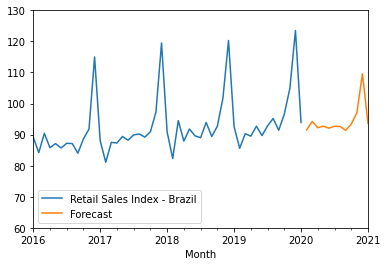

In [0]:
# Scaling the whole df
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
length = 24
# Generator
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=1)
model = Sequential()
model.add(LSTM(200, activation='relu',input_shape=(length,n_features), return_sequences=True))
model.add(LSTM(200, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit(generator, epochs=13)

# Forecasting the unknown future
forecast = []
periods = 12
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

# Creating df with forecast via for loop
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2020-02-01', periods=periods,
                               freq='MS')

forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                           columns=['Forecast'])

# Plotting
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2016-01-01','2021-03-01')
plt.ylim(60,130)

(60.0, 130.0)

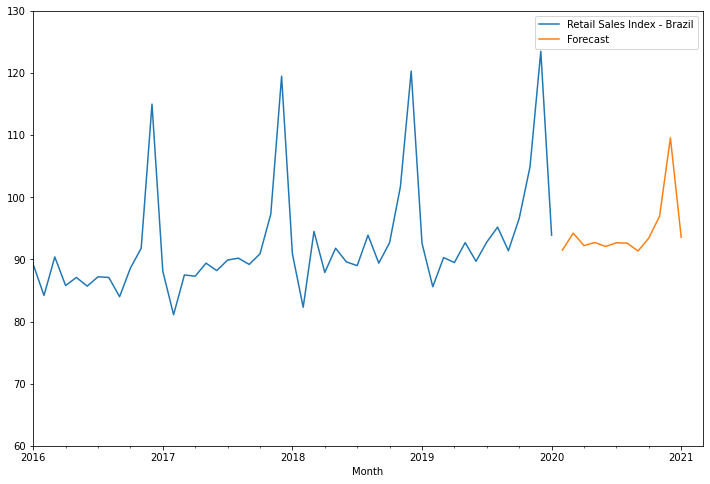

In [0]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.xlim('2016-01-01','2021-03-01')
plt.ylim(60,130)